In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import argparse
from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.fftpack import  fft, ifft, ifftshift
from scipy.signal import correlate
from sklearn.metrics import r2_score
import sys
from tqdm.auto import tqdm

sys.path.append('..')

from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *
from plot import *

# Load Chaotic Net Data

In [6]:
run_num = 0
chaotic_net_folder = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/chaotic_nets/chaotic_nets_multirun"

In [7]:
window = 500
transient = 2000
N = 512
num_indices = 50
T = 20000
noise_sd = 0.1

# Analyze

In [8]:
run_files = [f for f in os.listdir(chaotic_net_folder) if not f.endswith('DeLASE') and 'VAR' not in f]

for f in tqdm(run_files):
    if f == "RUN_ORIG":
            np.random.seed(41)
    else:
        np.random.seed(42 + int(f.split('_')[1]))

    run_ret = pd.read_pickle(os.path.join(chaotic_net_folder, f))

    indices = np.random.choice(np.arange(N), size=(num_indices, ), replace=False)

    full_signals = run_ret['signals']
    signals = {key: full_signal[:, indices] for key, full_signal in full_signals.items()}

    for key, signal in signals.items():
        signals[key] += np.random.randn(T, len(indices))*noise_sd

    A_mats = {}
    eigvals = {}
    for key, signal in signals.items():
        signal = signals[key][transient:transient + window]
        A = np.linalg.lstsq(signal[:-1], signal[1:], rcond=1e-20)[0].T
        A_mats[key] = A
        eigvals[key] = np.sort(np.abs(np.linalg.eigvals(A)))[::-1]

    ret = dict(
        A_mats=A_mats,
        eigvals=eigvals,
        lyaps=run_ret['lyaps']
    )

    pd.to_pickle(ret, os.path.join(chaotic_net_folder, f + "_VAR_small"))

  0%|          | 0/21 [00:00<?, ?it/s]

# Plot

In [9]:
g_min = 1.1
g_max = 1.8 


In [10]:
run_files = [f for f in os.listdir(chaotic_net_folder) if not f.endswith('DeLASE') and 'VAR' not in f]
all_rets = []
for f in run_files:
    all_rets.append(pd.read_pickle(os.path.join(chaotic_net_folder, f + "_VAR_small")))

In [11]:
g_vals = np.array(list(all_rets[0]['lyaps'].keys()))
g_vals = g_vals[(g_vals >= g_min) & (g_vals <= g_max)]

In [12]:
top_percent = 0.1

In [13]:
k = len(g_vals)
mean_lyaps = np.zeros(k)
mean_stab = np.zeros(k)
# mean_nonnorm = np.zeros(k)

counts_lyaps = np.zeros(k)
counts_stab = np.zeros(k)
# counts_nonnorm = np.zeros(k)

for ret in all_rets:
    mean_lyaps += np.array([ret['lyaps'][key][0] for key in g_vals])
    counts_lyaps += 1
    
    mean_stab += np.array([ret['eigvals'][key][:int(top_percent*len(ret['eigvals'][key]))].sum() for key in g_vals])
    counts_stab += np.array([int(top_percent*len(ret['eigvals'][key])) for key in g_vals])
    
#     mean_nonnorm += np.array([ret['nonnormalities'][key] for key in g_vals])
#     counts_nonnorm += 1
    
mean_lyaps /= counts_lyaps
mean_stab /= counts_stab
# mean_nonnorm /= counts_nonnorm

In [14]:

se_lyaps = np.zeros(k)
se_stab = np.zeros(k)
# se_nonnorm = np.zeros(k)

for ret in all_rets:
    se_lyaps += (np.array([ret['lyaps'][key][0] for key in g_vals]) - mean_lyaps)**2
    
    se_stab +=  np.array([((ret['eigvals'][key][:int(top_percent*len(ret['eigvals'][key]))] - mean_stab[np.where(g_vals == key)[0]])**2).sum() for key in g_vals])
    
#     se_nonnorm += (np.array([ret['nonnormalities'][key] for key in g_vals]) - mean_nonnorm)**2

se_lyaps /= counts_lyaps
se_lyaps = np.sqrt(se_lyaps)
se_lyaps /= np.sqrt(counts_lyaps)

se_stab /= counts_stab
se_stab = np.sqrt(se_stab)
se_stab /= np.sqrt(counts_stab)

# se_nonnorm /= counts_nonnorm
# se_nonnorm = np.sqrt(se_nonnorm)
# se_nonnorm /= np.sqrt(counts_nonnorm)

In [15]:
k = len(g_vals)
mean_lyaps_delase = np.zeros(k)
mean_stab_delase = np.zeros(k)
# mean_nonnorm = np.zeros(k)

counts_lyaps_delase = np.zeros(k)
counts_stab_delase = np.zeros(k)
# counts_nonnorm = np.zeros(k)

for ret in all_rets_delase:
    mean_lyaps_delase += np.array([ret['lyaps'][key] for key in g_vals])
    counts_lyaps_delase += 1
    
    mean_stab_delase += np.array([ret['stab_curves'][key][:int(top_percent*len(ret['stab_curves'][key]))].sum() for key in g_vals])
    counts_stab_delase += np.array([int(top_percent*len(ret['stab_curves'][key])) for key in g_vals])
    
#     mean_nonnorm += np.array([ret['nonnormalities'][key] for key in g_vals])
#     counts_nonnorm += 1
    
mean_lyaps_delase /= counts_lyaps_delase
mean_stab_delase /= counts_stab_delase
# mean_nonnorm /= counts_nonnorm

NameError: name 'all_rets_delase' is not defined

In [16]:

se_lyaps_delase = np.zeros(k)
se_stab_delase = np.zeros(k)
# se_nonnorm = np.zeros(k)

for ret in all_rets_delase:
    se_lyaps_delase += (np.array([ret['lyaps'][key] for key in g_vals]) - mean_lyaps_delase)**2
    
    se_stab_delase +=  np.array([((ret['stab_curves'][key][:int(top_percent*len(ret['stab_curves'][key]))] - mean_stab_delase[np.where(g_vals == key)[0]])**2).sum() for key in g_vals])
    
#     se_nonnorm += (np.array([ret['nonnormalities'][key] for key in g_vals]) - mean_nonnorm)**2

se_lyaps_delase /= counts_lyaps_delase
se_lyaps_delase = np.sqrt(se_lyaps_delase)
se_lyaps_delase /= np.sqrt(counts_lyaps_delase)

se_stab_delase /= counts_stab_delase
se_stab_delase = np.sqrt(se_stab_delase)
se_stab_delase /= np.sqrt(counts_stab_delase)

# se_nonnorm /= counts_nonnorm
# se_nonnorm = np.sqrt(se_nonnorm)
# se_nonnorm /= np.sqrt(counts_nonnorm)

NameError: name 'all_rets_delase' is not defined

In [17]:
all_rets_delase = []
for ret_file in tqdm(run_files):
    signal_rets = pd.read_pickle(os.path.join(chaotic_net_folder, ret_file))
    all_rets_delase.append({'lyaps': {key: signal_rets['lyaps'][key][0] for key in signal_rets['lyaps'].keys() if key >= g_min and key <= g_max}})
    delase_rets = pd.read_pickle(os.path.join(chaotic_net_folder, ret_file + '_DeLASE'))
    window, matrix_size, r, all_results = combine_grid_results({key: delase_rets[key] for key in delase_rets.keys() if key >= g_min and key <= g_max})
    all_rets_delase[-1]['stab_curves'] = {key: delase_rets[key].loc[(window, matrix_size, r)].stab_curves for key in delase_rets.keys() if key >= g_min and key <= g_max}
    
#     if ret_file == "RUN_ORIG":
#         np.random.seed(41)
#     else:
#         np.random.seed(42 + int(ret_file.split('_')[1]))

#     run_ret = signal_rets

#     indices = np.random.choice(np.arange(N), size=(num_indices, ), replace=False)

#     full_signals = run_ret['signals']
#     signals = {key: full_signal[:, indices] for key, full_signal in full_signals.items()}

#     for key in signals.keys():
#         signals[key] += np.random.randn(T, len(indices))*noise_sd

  0%|          | 0/21 [00:00<?, ?it/s]

AttributeError: Can't get attribute '_unpickle_block' on <module 'pandas._libs.internals' from '/om2/user/eisenaj/anaconda/envs/dynamical-trajectories/lib/python3.9/site-packages/pandas/_libs/internals.cpython-39-x86_64-linux-gnu.so'>

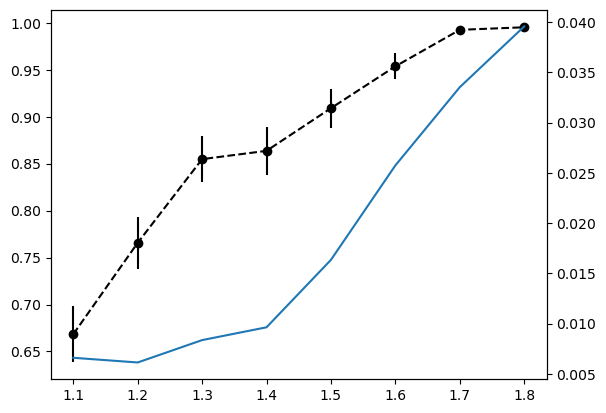

In [221]:

ax = plt.gca()
ax.errorbar(g_vals, mean_stab, yerr=se_stab, c='k', linestyle='--', marker='o', markersize=6, )
ax2 = plt.gca().twinx()
ax2.plot(g_vals, mean_lyaps, c='C0')